In [4]:
import os
import datetime

# Numerical computing and data handling
import numpy as np
import pandas as pd
from scipy.linalg import eigh # For linear algebra operations
#from tqdm import tqdm

# Machine learning and data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Joblib for saving and loading models or scalers
import joblib

# Visualization
import matplotlib.pyplot as plt

In [6]:
#####  GAT model for general system ###########
###################################################
# Dataset Class
###################################################
class GraphDataset(Dataset):
    def __init__(self, node_feats, eigen_pe, susceptance_matrix, target, indices):
        self.node_feats = node_feats
        self.eigen_pe = eigen_pe
        self.sus_matrix = susceptance_matrix
        self.target = target
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        return (self.node_feats[i], self.eigen_pe[i], self.sus_matrix[i], self.target[i])

###################################################
class SusTransformer(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, sus):
        return self.net(sus)

###################################################
###################################################
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads=4, concat_heads=True, alpha=0.2, dropout=0.1, residual = True, norm='layernorm', sus_hidden_dim=8):
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        self.residual = residual

        if self.concat_heads:
            assert c_out % num_heads == 0
            self.head_dim = c_out // num_heads
            self.final_out_dim = c_out
        else:
            self.head_dim = c_out
            self.final_out_dim = c_out

        self.projection = nn.Linear(c_in, self.num_heads*self.head_dim, bias=False)   ###  check
        self.a = nn.Parameter(torch.Tensor(num_heads, 2*self.head_dim + 1))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout_layer = nn.Dropout(p=dropout)
        self.sus_transform = SusTransformer(hidden_dim=sus_hidden_dim)

        if norm.lower() == 'layernorm':
            self.norm = nn.LayerNorm(self.final_out_dim)
        elif norm.lower() == 'batchnorm':
            self.norm = nn.BatchNorm1d(self.final_out_dim)
        else:
            raise ValueError("norm must be 'layernorm' or 'batchnorm'")

        if self.residual and c_in != self.final_out_dim:
            self.residual_transform = nn.Linear(c_in, self.final_out_dim, bias=False)  ## check
        else:
            self.residual_transform = None

        nn.init.xavier_uniform_(self.projection.weight, gain=1.414)
        nn.init.xavier_uniform_(self.a, gain=1.414)

    def forward(self, node_feats, susceptance_matrix):
        B, N, _ = node_feats.size()
        node_feats_proj = self.projection(node_feats)
        node_feats_proj = node_feats_proj.view(B, N, self.num_heads, self.head_dim)

        hi = node_feats_proj.unsqueeze(2).expand(B, N, N, self.num_heads, self.head_dim)
        hj = node_feats_proj.unsqueeze(1).expand(B, N, N, self.num_heads, self.head_dim)

        sus_flat = susceptance_matrix.view(B*N*N, 1)
        sus_transformed = self.sus_transform(sus_flat)
        sus_transformed = sus_transformed.view(B, N, N, 1)
        sus_transformed = sus_transformed.unsqueeze(3).expand(B, N, N, self.num_heads, 1)

        a_input = torch.cat([hi, sus_transformed, hj], dim=-1)

        attn_logits = torch.einsum('bnmhx,hx->bnmh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        attn_probs = F.softmax(attn_logits, dim=2)
        attn_probs = self.dropout_layer(attn_probs)

        out = torch.einsum('bnmh,bnmhd->bnhd', attn_probs, hj)

        if self.concat_heads:
            out = out.reshape(B, N, self.num_heads*self.head_dim)
        else:
            out = out.mean(dim=2)

        if self.residual:
            if self.residual_transform is not None:
                res = self.residual_transform(node_feats)
            else:
                res = node_feats
            out = out + res

        if isinstance(self.norm, nn.BatchNorm1d):
            out_t = out.transpose(1,2)
            out_t = self.norm(out_t)
            out = out_t.transpose(1,2)
        else:
            out = self.norm(out)

        return out

###################################################
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.mlp(x)
###################################################
class GATwithMLP(nn.Module):
    def __init__(self, c_in=58, c_hidden=64, c_out=1, num_heads=4, sus_hidden_dim=16, alpha=0.2, dropout=0.1, norm='layernorm', k=24, mlp_hidden = 128, residual = True, concat_heads = True):
        super().__init__()

        class EigenPETransform(nn.Module):
            def __init__(self, k, out_dim):
                super().__init__()
                self.linear1 = nn.Linear(k, 128)  # First linear layer
                self.relu1 = nn.ReLU()  # Shared ReLU activation
                self.linear2 = nn.Linear(128, out_dim)  # Second linear layer
                self.relu2 = nn.ReLU()
            def forward(self, x):
                x = self.relu1(self.linear1(x))
                return self.relu2(self.linear2(x))
        
        self.c_in = c_in
        self.c_hidden = c_hidden
        self.c_out = c_out
        self.num_heads = num_heads
        self.sus_hidden_dim = sus_hidden_dim
        self.alpha = alpha
        self.dropout = dropout
        self.norm = norm
        self.k = k
        self.mlp_hidden = mlp_hidden
        self.residual = residual
        self.concat_heads = concat_heads
    
    
        self.eigen_transform = EigenPETransform(k=self.k, out_dim=self.c_in)

        self.gat1 = GATLayer(
            self.c_in, self.c_hidden, num_heads=self.num_heads, concat_heads=self.concat_heads,
            alpha=self.alpha, dropout=self.dropout, residual = self.residual,
            norm=self.norm, sus_hidden_dim=self.sus_hidden_dim
        )
        self.gat2 = GATLayer(
            self.c_hidden, self.c_hidden, num_heads=self.num_heads, concat_heads=self.concat_heads,
            alpha=alpha, dropout=dropout, residual = self.residual,
            norm=norm, sus_hidden_dim=sus_hidden_dim
        )
        self.gat3 = GATLayer(
            self.c_hidden, self.c_hidden, num_heads=self.num_heads, concat_heads=self.concat_heads,
            alpha=self.alpha, dropout=self.dropout, residual = self.residual,
            norm=self.norm, sus_hidden_dim=self.sus_hidden_dim
        )
        self.mlp = MLPRegressor(input_dim=self.c_hidden, hidden_dim=self.mlp_hidden, output_dim=self.c_out)

    def forward(self, node_feats, eigen_pe, sus):

        # Transform eigen positional encodings and combine with node features
        eigen_pe_transformed = self.eigen_transform(eigen_pe)  # [B, N, c_in]
        x = node_feats + eigen_pe_transformed  # [B, N, c_in]

        # Pass through GAT layers
        x = self.gat1(x, sus)
        x = self.gat2(x, sus)
        x = self.gat3(x, sus)

        # Pool over nodes and pass through MLP
        x = x.mean(dim=1)  # Global pooling over nodes [B, c_hidden]
        out = self.mlp(x)  # Final prediction [B, c_out]
        return out

In [3]:
parent_dir = os.getcwd()
print(parent_dir)

/ztank/scratch/user/u.rd143338/24 bus system/ACES continue


In [4]:
## load the input 
node_feats = []
sus_matrices = []
pos_enc = []
target = []

node_feats = np.load(os.path.join(parent_dir, "pre NN data", f"feature_load_array_norm2.npy"))
sus_matrices = np.load(os.path.join(parent_dir, "pre NN data", f"sus_matrix_norm2.npy"))
pos_enc = np.load(os.path.join(parent_dir, "pre NN data", f"pos_enc_norm2.npy"))
target = np.load(os.path.join(parent_dir, "pre NN data", f"target_norm2.npy")).reshape(-1,1)

In [5]:
num_inputs, num_bus, num_feats = node_feats.shape
print(num_inputs, num_bus, num_feats)

437600 24 58


In [5]:
seed = 42
# Step 1: Split into training and temporary (80% training, 20% temporary)
node_feats_train, node_feats_temp, sus_matrices_train, sus_matrices_temp, pos_enc_train, pos_enc_temp, target_train, target_temp = train_test_split(
    node_feats, sus_matrices, pos_enc, target, test_size=0.1, random_state=seed
)

# Step 2: Split temporary set into validation and testing (50% each of temporary, i.e., 10% each of original data)
node_feats_val, node_feats_test, sus_matrices_val, sus_matrices_test, pos_enc_val, pos_enc_test, target_val, target_test = train_test_split(
    node_feats_temp, sus_matrices_temp, pos_enc_temp, target_temp, test_size=0.5, random_state=seed
)

# Check the resulting shapes
print(f"Training set shapes: {node_feats_train.shape}, {sus_matrices_train.shape}, {pos_enc_train.shape}, {target_train.shape}")
print(f"Validation set shapes: {node_feats_val.shape}, {sus_matrices_val.shape}, {pos_enc_val.shape}, {target_val.shape}")
print(f"Testing set shapes: {node_feats_test.shape}, {sus_matrices_test.shape}, {pos_enc_test.shape}, {target_test.shape}")

Training set shapes: (393840, 24, 58), (393840, 24, 24), (393840, 24, 24), (393840, 1)
Validation set shapes: (21880, 24, 58), (21880, 24, 24), (21880, 24, 24), (21880, 1)
Testing set shapes: (21880, 24, 58), (21880, 24, 24), (21880, 24, 24), (21880, 1)


In [6]:
# 1) Fit the node feats' scaler only on the TRAINING set
node_feats_train_2d = node_feats_train.reshape(-1, node_feats_train.shape[-1])
node_scaler = StandardScaler()
node_feats_train_2d_scaled = node_scaler.fit_transform(node_feats_train_2d)
node_feats_train_scaled = node_feats_train_2d_scaled.reshape(node_feats_train.shape)

# 2) Transform the VALIDATION set using the scaler fitted on TRAIN
node_feats_val_2d = node_feats_val.reshape(-1, node_feats_val.shape[-1])
node_feats_val_2d_scaled = node_scaler.transform(node_feats_val_2d)
node_feats_val_scaled = node_feats_val_2d_scaled.reshape(node_feats_val.shape)

# 3) Transform the TEST set using the scaler fitted on TRAIN
node_feats_test_2d = node_feats_test.reshape(-1, node_feats_test.shape[-1])
node_feats_test_2d_scaled = node_scaler.transform(node_feats_test_2d)
node_feats_test_scaled = node_feats_test_2d_scaled.reshape(node_feats_test.shape)

# 4) Save the fitted scaler
scaler_path = os.path.join(parent_dir, "post NN data", "node_scaler.pkl")
joblib.dump(node_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /ztank/scratch/user/u.rd143338/24 bus system/ACES continue/post NN data/node_scaler.pkl


In [7]:
sus_scaler = StandardScaler()
sus_matrices_1d = sus_scaler.fit_transform(sus_matrices_train.reshape(-1,1))
sus_matrices_train_scaled = sus_matrices_1d.reshape(sus_matrices_train.shape)

sus_matrices_1d = sus_scaler.transform(sus_matrices_val.reshape(-1,1))
sus_matrices_val_scaled = sus_matrices_1d.reshape(sus_matrices_val.shape)

sus_matrices_1d = sus_scaler.transform(sus_matrices_test.reshape(-1,1))
sus_matrices_test_scaled = sus_matrices_1d.reshape(sus_matrices_test.shape)

scaler_path = os.path.join(parent_dir, "post NN data", "sus_scaler.pkl")
joblib.dump(sus_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /ztank/scratch/user/u.rd143338/24 bus system/ACES continue/post NN data/sus_scaler.pkl


In [8]:
sus_scaler.mean_

array([-7.81558721e-17])

In [9]:
# # 1) Fit the scaler only on the TRAINING target
target_scaler = StandardScaler()
target_train_scaled = target_scaler.fit_transform(target_train)

# 2) Transform the VALIDATION and TEST targets using the scaler fitted on TRAIN
target_val_scaled = target_scaler.transform(target_val)
target_test_scaled = target_scaler.transform(target_test)

# 3) Save the fitted target scaler
target_scaler_path = os.path.join(parent_dir, "post NN data", "target_scaler.pkl")
joblib.dump(target_scaler, target_scaler_path)
print(f"Target scaler saved to {target_scaler_path}")

Target scaler saved to /ztank/scratch/user/u.rd143338/24 bus system/ACES continue/post NN data/target_scaler.pkl


In [10]:
target.min()

407599.9104217334

In [11]:
target.max()

1159474.462484567

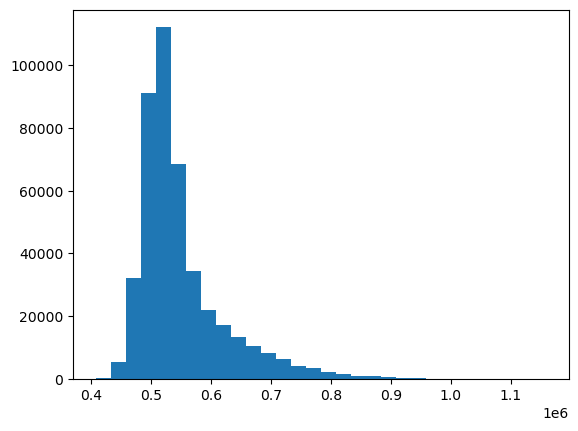

In [12]:
plt.hist(target.reshape(-1), bins =30)
plt.show()

In [14]:
#################### Scaling complete ###################################

## Create Dataloaders

In [13]:
## convert to tensors
# Train
node_feats_train_tensor = torch.from_numpy(node_feats_train_scaled).float()
pos_enc_train_tensor    = torch.from_numpy(pos_enc_train).float()
sus_matrices_train_tensor = torch.from_numpy(sus_matrices_train_scaled).float()
target_train_tensor     = torch.from_numpy(target_train_scaled).float()

# Validation
node_feats_val_tensor   = torch.from_numpy(node_feats_val_scaled).float()
pos_enc_val_tensor      = torch.from_numpy(pos_enc_val).float()
sus_matrices_val_tensor   = torch.from_numpy(sus_matrices_val_scaled).float()
target_val_tensor       = torch.from_numpy(target_val_scaled).float()

# Test
node_feats_test_tensor  = torch.from_numpy(node_feats_test_scaled).float()
pos_enc_test_tensor     = torch.from_numpy(pos_enc_test).float()
sus_matrices_test_tensor  = torch.from_numpy(sus_matrices_test_scaled).float()
target_test_tensor      = torch.from_numpy(target_test_scaled).float()

train_indices = torch.arange(node_feats_train_tensor.shape[0])
val_indices   = torch.arange(node_feats_val_tensor.shape[0])
test_indices  = torch.arange(node_feats_test_tensor.shape[0])

train_dataset = GraphDataset(
    node_feats_train_tensor, 
    pos_enc_train_tensor,
    sus_matrices_train_tensor,
    target_train_tensor,
    train_indices
)

val_dataset = GraphDataset(
    node_feats_val_tensor, 
    pos_enc_val_tensor,
    sus_matrices_val_tensor,
    target_val_tensor,
    val_indices
)

test_dataset = GraphDataset(
    node_feats_test_tensor, 
    pos_enc_test_tensor,
    sus_matrices_test_tensor,
    target_test_tensor,
    test_indices
)


In [11]:
BATCH_SIZE = CONFIG["batch_size"]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)

NameError: name 'train_dataset' is not defined

In [10]:
CONFIG = {
    "model_args": {
        "c_in": 58,
        "c_hidden": 128,
        "c_out": 1,
        "num_heads": 4,
        "sus_hidden_dim": 4,
        "alpha": 0.1,
        "dropout": 0.15,
        "norm": "layernorm",
        "k": 24,
        "mlp_hidden": 128,
        "residual":True,
        "concat_heads":True
    },
    "optimizer_args": {
        "lr": 0.005,
    },
    "scheduler_args": {
        "mode": "min",
        "factor": 0.9,
        "patience": 30,
        "verbose": True,
    },
    "batch_size": 512,
    "epochs": 2000,
    "patience": 100,         # Early stopping patience
    "grad_clip_value": 1.0, # Gradient clipping (optional)
}


In [12]:
## define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAT_model = GATwithMLP(**CONFIG["model_args"]).to(device)

EPOCHS = CONFIG["epochs"]

optimizer = optim.Adamax(GAT_model.parameters(), **CONFIG["optimizer_args"])

criterion = nn.MSELoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    **CONFIG["scheduler_args"]
)

/scratch/user/u.rd143338/.conda/envs/ORL_CASUAL/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
### load the GAT model
### do not load for a new model

checkpoint_path_load = os.path.join("checkpoints","GAT_model_best_2025-01-15.pth")
pre_load_data = torch.load(checkpoint_path_load)
GAT_model.load_state_dict((pre_load_data["model_state_dict"]))
GAT_model.to(device)
train_losses = pre_load_data["train_losses"]
val_losses = pre_load_data["val_losses"]


In [39]:
# # 3) Prepare arrays (or lists) to store train/val losses
# train_losses = []
# val_losses = []

In [40]:
best_val_loss = pre_load_data["best_val_loss"]  # Keep track of the best validation loss seen so far
for epoch in range(EPOCHS):
    ########################################
    # Training
    ########################################
    GAT_model.train()
    running_train_loss = 0.0
    for node_feats, eigen_pe, sus_mat, targ in train_loader:
        node_feats = node_feats.to(device)
        eigen_pe   = eigen_pe.to(device)
        sus_mat    = sus_mat.to(device)
        targ       = targ.to(device)

        # Forward pass
        optimizer.zero_grad()
        pred = GAT_model(node_feats, eigen_pe, sus_mat)
        loss = criterion(pred, targ)

        # Backprop
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    # Average training loss over entire train set
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    ########################################
    # Validation
    ########################################
    GAT_model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for node_feats, eigen_pe, sus_mat, targ in val_loader:
            node_feats = node_feats.to(device)
            eigen_pe   = eigen_pe.to(device)
            sus_mat    = sus_mat.to(device)
            targ       = targ.to(device)

            pred = GAT_model(node_feats, eigen_pe, sus_mat)
            val_loss = criterion(pred, targ)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if epoch%10 == 0:
        # Print progress
        print(f"Epoch {epoch}/{EPOCHS} | "
                  f"Train Loss: {avg_train_loss:.7f} | "
                  f"Val Loss: {avg_val_loss:.7f} |"
                  f"learning rate: {optimizer.param_groups[0]['lr']}"
                  ) 

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # 6) Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        # Get the current date (and optionally time)
        current_time = datetime.datetime.now().strftime("%Y-%m-%d")

        checkpoint_name = f"GAT_model_best_{current_time}.pth"

        checkpoint_dict = {
            "epoch": epoch,
            "model_state_dict": GAT_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "model_args": CONFIG["model_args"],
            "train_losses": train_losses,
            "val_losses": val_losses,
            "best_val_loss": best_val_loss}
        
        save_path = os.path.join(
                "checkpoints",   # or wherever you want to save
                checkpoint_name
            )
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(checkpoint_dict, save_path)

Epoch 0/2000 | Train Loss: 0.0036684 | Val Loss: 0.0027162 |learning rate: 0.005
Epoch 10/2000 | Train Loss: 0.0031785 | Val Loss: 0.0037952 |learning rate: 0.005
Epoch 20/2000 | Train Loss: 0.0031742 | Val Loss: 0.0039557 |learning rate: 0.005
Epoch 30/2000 | Train Loss: 0.0031967 | Val Loss: 0.0041181 |learning rate: 0.005
Epoch 40/2000 | Train Loss: 0.0030100 | Val Loss: 0.0042474 |learning rate: 0.0045000000000000005
Epoch 50/2000 | Train Loss: 0.0029458 | Val Loss: 0.0035318 |learning rate: 0.0045000000000000005
Epoch 60/2000 | Train Loss: 0.0030114 | Val Loss: 0.0037547 |learning rate: 0.0045000000000000005
Epoch 70/2000 | Train Loss: 0.0028276 | Val Loss: 0.0038447 |learning rate: 0.004050000000000001
Epoch 80/2000 | Train Loss: 0.0027344 | Val Loss: 0.0034895 |learning rate: 0.004050000000000001
Epoch 90/2000 | Train Loss: 0.0027326 | Val Loss: 0.0034184 |learning rate: 0.004050000000000001
Epoch 100/2000 | Train Loss: 0.0025781 | Val Loss: 0.0034474 |learning rate: 0.003645000

In [42]:
### load the GAT model
checkpoint_path_load = os.path.join("checkpoints","GAT_model_best_2025-01-16.pth")
pre_load_data = torch.load(checkpoint_path_load)
GAT_model.load_state_dict((pre_load_data["model_state_dict"]))
GAT_model.to(device)
train_losses = pre_load_data["train_losses"]
val_losses = pre_load_data["val_losses"]

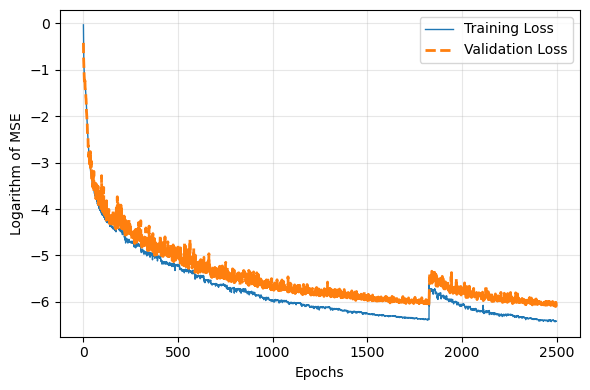

In [17]:
epochs_to_plot = 2500  # Limit to first 2500 epochs

plt.figure(figsize=(6, 4))  # Adjust figure size if needed
plt.plot(np.log(train_losses[:epochs_to_plot]), label='Training Loss', linestyle='-', linewidth=1)
plt.plot(np.log(val_losses[:epochs_to_plot]), label='Validation Loss', linestyle='--', linewidth=2)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Logarithm of MSE", fontsize=10)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)  # Subtle grid lines
plt.tight_layout()  # Ensures no clipping

# Save the plot as a high-resolution PNG file
plt.savefig("training_validation_loss.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()

/tmp/job.19525/ipykernel_253144/712802620.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pre_load_data = torch.load(checkpoint_path_load)


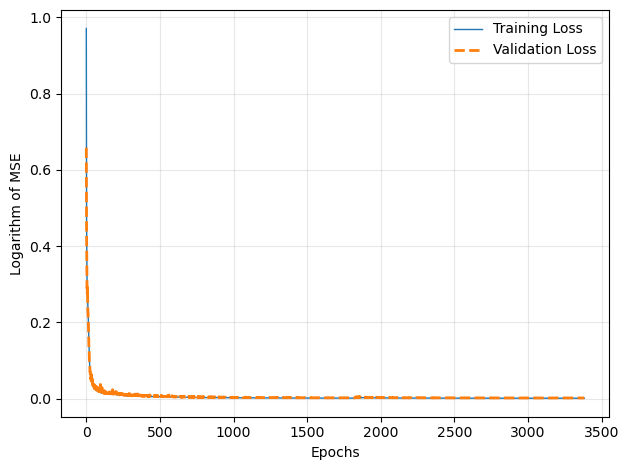

In [13]:
checkpoint_path_load = os.path.join("checkpoints","GAT_model_best_2025-01-16.pth")
pre_load_data = torch.load(checkpoint_path_load)
GAT_model.load_state_dict((pre_load_data["model_state_dict"]))
GAT_model.to(device)
train_losses = pre_load_data["train_losses"]
val_losses = pre_load_data["val_losses"]

plt.plot((train_losses), label='Training Loss', linestyle='-', linewidth=1)
plt.plot((val_losses), label='Validation Loss', linestyle='--', linewidth=2)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Logarithm of MSE", fontsize=10)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)  # Subtle grid lines
plt.tight_layout()  # Ensures no clipping
plt.show()

## Code for single file computation

In [21]:
# ---------------------------------------------------------
# 1) Centralized config: model args, training hyperparams
# ---------------------------------------------------------


In [22]:
# ----------------------------
# Helper: compute extra metrics
# ----------------------------
def compute_metrics(y_pred, y_true):
    """
    Compute MSE, MAE, RMSE for logging.
    """
    mse = nn.functional.mse_loss(y_pred, y_true).item()
    mae = nn.functional.l1_loss(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    return mse, mae, rmse

# ----------------------------
# Helper: train one epoch
# ----------------------------
def train_one_epoch(model, dataloader, optimizer, criterion, device, grad_clip=None):
    model.train()
    running_loss = 0.0
    
    for node_feats, eigen_pe, sus_mat, targ in dataloader:
        node_feats = node_feats.to(device)
        eigen_pe   = eigen_pe.to(device)
        sus_mat    = sus_mat.to(device)
        targ       = targ.to(device)

        optimizer.zero_grad()
        pred = model(node_feats, eigen_pe, sus_mat)
        loss = criterion(pred, targ)
        loss.backward()

        # Optional gradient clipping
        # if grad_clip is not None:
        #     nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        running_loss += loss.item()
    
    return running_loss / len(dataloader)

# ----------------------------
# Helper: validate one epoch
# ----------------------------
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targs = [], []

    with torch.no_grad():
        for node_feats, eigen_pe, sus_mat, targ in dataloader:
            node_feats = node_feats.to(device)
            eigen_pe   = eigen_pe.to(device)
            sus_mat    = sus_mat.to(device)
            targ       = targ.to(device)

            pred = model(node_feats, eigen_pe, sus_mat)
            loss = criterion(pred, targ)
            running_loss += loss.item()

            all_preds.append(pred.detach().cpu())
            all_targs.append(targ.detach().cpu())
    
    avg_loss = running_loss / len(dataloader)
    all_preds = torch.cat(all_preds, dim=0)
    all_targs = torch.cat(all_targs, dim=0)

    # Extra metrics
    mse, mae, rmse = compute_metrics(all_preds, all_targs)
    return avg_loss, mse, mae, rmse


In [23]:
# ---------------------------
# MAIN: Putting it all together
# ---------------------------
def main():
    # ----------------------------------------------------
    # A) Setup
    # ----------------------------------------------------
    # device
    device = "cuda"
    #torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CONFIG["batch_size"], 
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=CONFIG["batch_size"], 
        shuffle=False
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG["batch_size"], 
        shuffle=False
    )

    # Model
    model = GATwithMLP(**CONFIG["model_args"]).to(device)

    # Optimizer
    optimizer = optim.Adamax(model.parameters(), **CONFIG["optimizer_args"])

    # Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        **CONFIG["scheduler_args"]
    )

    # Loss function
    criterion = nn.MSELoss()

    # Arrays to store losses per epoch
    train_losses = []
    val_losses = []

    # Early stopping
    best_val_loss = float("inf")
    epochs_no_improve = 0

    # ----------------------------------------------------
    # B) Training loop
    # ----------------------------------------------------
    print(f"Starting training for {CONFIG['epochs']} epochs...")

    for epoch in range(1, CONFIG["epochs"] + 1):
        # --- TRAIN ---
        train_loss = train_one_epoch(
            model=model,
            dataloader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            grad_clip=CONFIG["grad_clip_value"],
        )

        # --- VALIDATE ---
        val_loss, val_mse, val_mae, val_rmse = validate_one_epoch(
            model=model,
            dataloader=val_loader,
            criterion=criterion,
            device=device,
        )
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the scheduler
        scheduler.step(val_loss)

        # if epoch%10==1:
        #     # Logging
        print(
            f"Epoch [{epoch}/{CONFIG['epochs']}] "
            f"Train Loss: {train_loss:.7f} | "
            f"Val Loss: {val_loss:.7f} | "
            f"Val MSE: {val_mse:.7f} | "
            f"Val MAE: {val_mae:.7f} | "
            f"Val RMSE: {val_rmse:.7f}"
        )

        # --- SAVE BEST MODEL (checkpoint) ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0

            # Name your checkpoint
            current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            checkpoint_name = f"GAT_model_best_{current_time}.pth"

            # This dict will include:
            # 1) Model state_dict
            # 2) Model hyperparams (CONFIG["model_args"])
            # 3) Optimizer state_dict (to potentially resume training)
            # 4) Training history (loss curves, etc.)
            # 5) Current epoch
            checkpoint_dict = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "model_args": CONFIG["model_args"],
                "train_losses": train_losses,
                "val_losses": val_losses,
                "best_val_loss": best_val_loss,
            }

            # Save the checkpoint
            save_path = os.path.join(
                "checkpoints",   # or wherever you want to save
                checkpoint_name
            )
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(checkpoint_dict, save_path)

            print(f"  -> New best model saved at {save_path}")
        else:
            epochs_no_improve += 1

        # --- EARLY STOPPING ---
        if epochs_no_improve >= CONFIG["patience"]:
            print("Early stopping triggered.")
            break

    # ----------------------------------------------------
    # C) Evaluate on Test Set
    # ----------------------------------------------------
    print("Evaluating on the test set...")
    test_loss, test_mse, test_mae, test_rmse = validate_one_epoch(
        model=model,
        dataloader=test_loader,
        criterion=criterion,
        device=device,
    )
    print(
        f"Test Loss: {test_loss:.7f} | "
        f"MSE: {test_mse:.7f} | "
        f"MAE: {test_mae:.7f} | "
        f"RMSE: {test_rmse:.7f}"
    )

    print("Training complete!")


In [24]:
main()

Using device: cpu


/scratch/user/u.rd143338/.conda/envs/bayesian_PI/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting training for 2000 epochs...
Epoch [1/2000] Train Loss: 1.1025333 | Val Loss: 1.0003355 | Val MSE: 1.0003895 | Val MAE: 0.7851691 | Val RMSE: 1.0001947
  -> New best model saved at checkpoints/GAT_model_best_2025-01-06_19-36-15.pth
Epoch [2/2000] Train Loss: 1.0006562 | Val Loss: 0.9996261 | Val MSE: 0.9996796 | Val MAE: 0.7840574 | Val RMSE: 0.9998398
  -> New best model saved at checkpoints/GAT_model_best_2025-01-06_19-39-33.pth
Epoch [3/2000] Train Loss: 1.0012159 | Val Loss: 0.9995272 | Val MSE: 0.9995808 | Val MAE: 0.7838690 | Val RMSE: 0.9997904
  -> New best model saved at checkpoints/GAT_model_best_2025-01-06_19-42-54.pth
Epoch [4/2000] Train Loss: 1.0006791 | Val Loss: 0.9991509 | Val MSE: 0.9992040 | Val MAE: 0.7829058 | Val RMSE: 0.9996019
  -> New best model saved at checkpoints/GAT_model_best_2025-01-06_19-46-16.pth
Epoch [5/2000] Train Loss: 0.9987985 | Val Loss: 0.9991098 | Val MSE: 0.9991629 | Val MAE: 0.7827299 | Val RMSE: 0.9995813
  -> New best model saved at

KeyboardInterrupt: 